The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


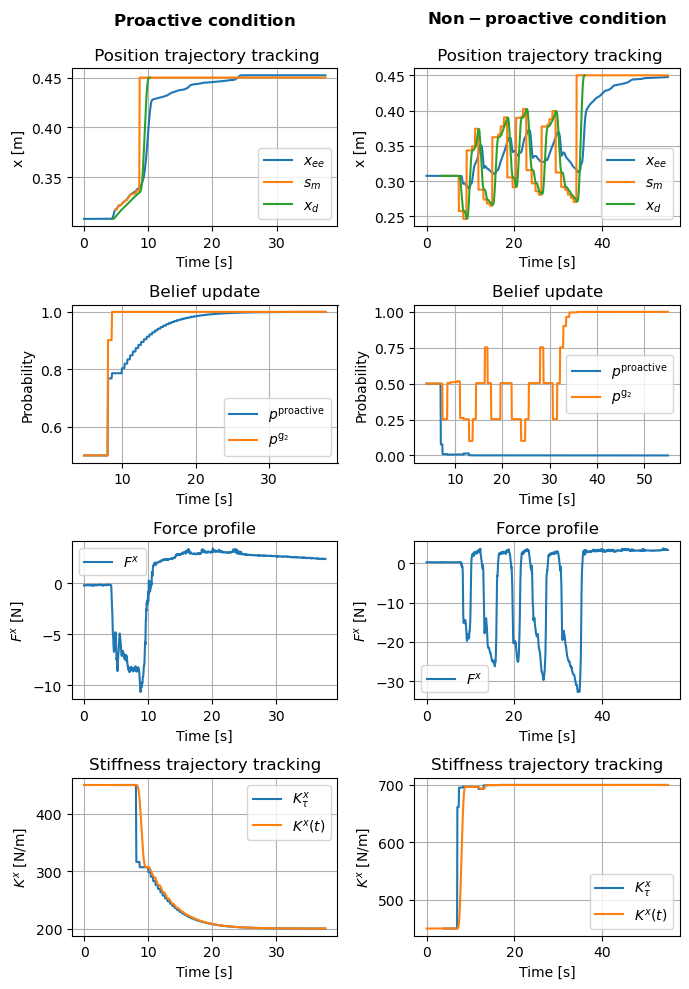

In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from std_msgs.msg import Float32

# Path to your ROS bag file
bag_path = '/home/bal/overlay_noetic_ws/src/active_inference_planner/data/2024-07-10-15-25-20-proactive-varK-int.bag'
bag_path_2 = '/home/bal/overlay_noetic_ws/src/active_inference_planner/data/2024-07-10-15-23-07-not-proactive-barK-int.bag'

# Topic you want to plot
topic_name = '/active_inference/pose_set_point'


# Initialize a list to store dictionaries {time, data}
data_list = []

# Topics you want to plot
topics_pose = ['/my_cartesian_impedance_controller/curr_ee_pose']
topics_pose_stamped = ['/active_inference/pose_set_point', 
          '/my_cartesian_impedance_controller/equilibrium_pose']
topics_proactivity = ['/active_inference/belief']
topics_not_proactivity = ['/active_inference/belief']
topics_stiffness = ['/active_inference/stiffness_set_point', '/my_cartesian_impedance_controller/stiffness_target']
topics_goal = ['/active_inference/belief']
topics_force = ['/franka_state_controller/F_ext']


def get_data_from_bag(bag_path, topics_pose, topics_pose_stamped, topics_proactivity, topics_not_proactivity, topics_stiffness, topics_goal, topics_force):
    """
    Extract data from a ROS bag file and store it in a dictionary of DataFrames.
    """
    # Initialize a dictionary to store DataFrames for each topic
    dfs = {}
    dfs_proactive = {}
    dfs_not_proactive = {}
    dfs_stiffness = {}
    dfs_goal = {}
    dfs_force = {}
    # Open the ROS bag file
    with rosbag.Bag(bag_path) as bag:
        for topic in topics_pose:
            data_list = []
            for _, msg, t in bag.read_messages(topics=[topic]):
                # Convert ROS Time to seconds and store data
                data_list.append({'Time': t.to_sec(), 'Data': msg.position.x})
            # Convert list to DataFrame and store in dictionary
            dfs[topic] = pd.DataFrame(data_list)
        for topic in topics_pose_stamped:
            data_list = []
            for _, msg, t in bag.read_messages(topics=[topic]):
                # Convert ROS Time to seconds and store data
                data_list.append({'Time': t.to_sec(), 'Data': msg.pose.position.x})
            # Convert list to DataFrame and store in dictionary
            dfs[topic] = pd.DataFrame(data_list)
        for topic in topics_proactivity:
            data_list = []
            for _, msg, t in bag.read_messages(topics=[topic]):
                # Convert ROS Time to seconds and store data
                data_list.append({'Time': t.to_sec(), 'Data': msg.proactive_state_values[1]})
            # Convert list to DataFrame and store in dictionary
            dfs_proactive[topic] = pd.DataFrame(data_list)
        for topic in topics_not_proactivity:
            data_list = []
            for _, msg, t in bag.read_messages(topics=[topic]):
                # Convert ROS Time to seconds and store data
                data_list.append({'Time': t.to_sec(), 'Data': msg.proactive_state_values[0]})
            # Convert list to DataFrame and store in dictionary
            dfs_not_proactive[topic] = pd.DataFrame(data_list)
        for topic in topics_stiffness: 
            data_list = []
            for _, msg, t in bag.read_messages(topics=[topic]):
                # Convert ROS Time to seconds and store data
                data_list.append({'Time': t.to_sec(), 'Data': msg.data})
            # Convert list to DataFrame and store in dictionary
            dfs_stiffness[topic] = pd.DataFrame(data_list)
        for topic in topics_goal:    
            data_list = []
            for _, msg, t in bag.read_messages(topics=[topic]):
                # Convert ROS Time to seconds and store data
                data_list.append({'Time': t.to_sec(), 'Data': msg.goal_state_values[1]})
            # Convert list to DataFrame and store in dictionary
            dfs_goal[topic] = pd.DataFrame(data_list)
        for topic in topics_force:
            data_list = []
            for _, msg, t in bag.read_messages(topics=[topic]):
                # Convert ROS Time to seconds and store data
                data_list.append({'Time': t.to_sec(), 'Data': msg.wrench.force.x})
            # Convert list to DataFrame and store in dictionary
            dfs_force[topic] = pd.DataFrame(data_list)

    return dfs, dfs_proactive, dfs_not_proactive, dfs_stiffness, dfs_goal, dfs_force

# Call the function to get data
dfs, dfs_proactive, dfs_not_proactive, dfs_stiffness, dfs_goal, dfs_force = get_data_from_bag(bag_path, topics_pose, topics_pose_stamped, topics_proactivity, topics_not_proactivity, topics_stiffness, topics_goal, topics_force)

dfs_2, dfs_proactive_2, dfs_not_proactive_2, dfs_stiffness_2, dfs_goal_2, dfs_force_2 = get_data_from_bag(bag_path_2, topics_pose, topics_pose_stamped, topics_proactivity, topics_not_proactivity, topics_stiffness, topics_goal, topics_force)

# Plotting
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 2, figsize=(7, 10))  # Adjust the size as needed

labels={'/my_cartesian_impedance_controller/curr_ee_pose':'$x_{ee}$',
        '/active_inference/pose_set_point':"$s_{m}$",
        '/my_cartesian_impedance_controller/equilibrium_pose':"$x_d$",
        '/active_inference/belief':'$p_{\mathrm{not-proactive}}$',
        '/active_inference/stiffness_set_point':'$K^{x}_{\\tau}$',
        '/my_cartesian_impedance_controller/stiffness_target':'$K^{x}(t)$',
        '/franka_state_controller/F_ext':'$F^x$',
        '/active_inference/belief':['$p^{\mathrm{proactive}}$', '$p^{\mathrm{not - proactive}}$', '$p^{\mathrm{g_2}}$']}


def plot_data(axs, dfs, dfs_proactive, dfs_not_proactive, dfs_stiffness, dfs_goal, dfs_force, labels, title=''):
    """
    Plot data from the DataFrames.
    """

    min_time = min(df['Time'].min() for df in dfs.values())  # Find the global minimum time

    max_time = 55.0
    for topic, df in dfs.items():
    # Normalize time data: subtract the global minimum time
        df['Normalized Time'] = df['Time'] - min_time
        # Filter to include only the first 40 seconds after normalization
        filtered_df = df[df['Normalized Time'] <= max_time]
        axs[0].plot(filtered_df['Normalized Time'], filtered_df['Data'], label=labels[topic])
        axs[0].set_xlabel('Time [s]')
        axs[0].set_ylabel('x [m]')
        axs[0].set_title('$\\bf{' + title + '}$' + '\n\n Position trajectory tracking')
        axs[0].legend()


    for topic, df in dfs_proactive.items():
    # Normalize time data: subtract the global minimum time
        df['Normalized Time'] = df['Time'] - min_time
        # Filter to include only the first 40 seconds after normalization
        filtered_df = df[df['Normalized Time'] <= max_time]
        axs[1].plot(filtered_df['Normalized Time'], filtered_df['Data'], label=labels[topic][0])
        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('Probability')
        axs[1].set_title('Belief update')
        axs[1].legend()

    #for topic, df in dfs_not_proactive.items():
    ## Normalize time data: subtract the global minimum time
    #    df['Normalized Time'] = df['Time'] - min_time
    #    # Filter to include only the first 40 seconds after normalization
    #    filtered_df = df[df['Normalized Time'] <= max_time]
    #    axs[0][1].plot(filtered_df['Normalized Time'], filtered_df['Data'], label=labels[topic][1])
    #    axs[0][1].set_xlabel('Time [s]')
    #    axs[0][1].set_ylabel('Probability')
    #    axs[0][1].set_title('Belief update')
    #    axs[0][1].legend()

    for topic, df in dfs_goal.items():
    # Normalize time data: subtract the global minimum time
        df['Normalized Time'] = df['Time'] - min_time
        # Filter to include only the first 40 seconds after normalization
        filtered_df = df[df['Normalized Time'] <= max_time]
        axs[1].plot(filtered_df['Normalized Time'], filtered_df['Data'], label=labels[topic][2])
        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('Probability')
        axs[1].legend()

    for topic, df in dfs_force.items():
        # Normalize time data: subtract the global minimum time
        df['Normalized Time'] = df['Time'] - min_time
        # Filter to include only the first 40 seconds after normalization
        filtered_df = df[df['Normalized Time'] <= max_time]
        axs[2].plot(filtered_df['Normalized Time'], filtered_df['Data'], label=labels[topic])
        axs[2].set_xlabel('Time [s]')
        axs[2].set_ylabel('$F^x$ [N]')
        axs[2].set_title('Force profile')
        axs[2].legend()

    for topic, df in dfs_stiffness.items():
    # Normalize time data: subtract the global minimum time
        df['Normalized Time'] = df['Time'] - min_time
        # Filter to include only the first 40 seconds after normalization
        filtered_df = df[df['Normalized Time'] <= max_time]
        axs[3].plot(filtered_df['Normalized Time'], filtered_df['Data'], label=labels[topic])
        axs[3].set_xlabel('Time [s]')
        axs[3].set_ylabel('$K^x$ [N/m]')
        axs[3].set_title('Stiffness trajectory tracking')
        axs[3].legend()

    # After each plotting section, enable the grid for that subplot
    axs[0].grid(True)  # For the first subplot
    axs[1].grid(True)  # For the second subplot
    axs[2].grid(True)  # For the third subplot
    axs[3].grid(True)  # For the fourth subplot

    return axs

# Call the function to plot data
plot_data(axs.T[0][:], dfs, dfs_proactive, dfs_not_proactive, dfs_stiffness, dfs_goal, dfs_force, labels, title='Proactive \\ condition')
plot_data(axs.T[1][:], dfs_2, dfs_proactive_2, dfs_not_proactive_2, dfs_stiffness_2, dfs_goal_2, dfs_force_2, labels, title='Non-proactive \\ condition')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig('/home/bal/combined_proactive_notpro.eps', format='eps', bbox_inches='tight')
plt.show()

